# Notebook 1

This notebook was created to build and finalize the model with some hyperparameter tuning.This notebook uses subset of the main dataset. The subset of the main dataset can be found under **small_dataset** folder. After running and testing the model I implemented the final version of the model to **notebook_2.ipynb**. Please see that file for better understandings!

# Dataset Downloading

In [1]:
# !pip install gdown

In [2]:
# import gdown 

# file_id = "1EchppP3u-RQ1sgnQaT2KZ68O3phg9Pag"

# # Download the file
# url = f'https://drive.google.com/uc?id={file_id}'
# gdown.download(url, quiet=False)

In [3]:
# !unzip dataset.zip

# Installation

In [4]:
!pip install seaborn

In [5]:
!pip install scikeras

In [6]:
# Install OpenCV using pip
!pip install opencv-python-headless

In [7]:
!pip install scikit-learn

In [8]:
!pip install numpy==1.22


In [9]:
!pip install scikit-image

In [10]:
!pip install keras-tuner

# Dependencies

In [11]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import cv2
import numpy as np
import shutil
import random

from random import sample
from PIL import Image
from skimage import feature
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras_tuner.tuners import RandomSearch

2023-12-17 08:24:09.080704: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


# EDA

In [12]:
# Open an image file
img = Image.open('dataset/train/Apple___Apple_scab/00075aa8-d81a-4184-8541-b692b78d398a___FREC_Scab 3335.JPG')
# Get image size
width, height = img.size

print(f"The image width is {width} and the image height is {height}")

The image width is 256 and the image height is 256


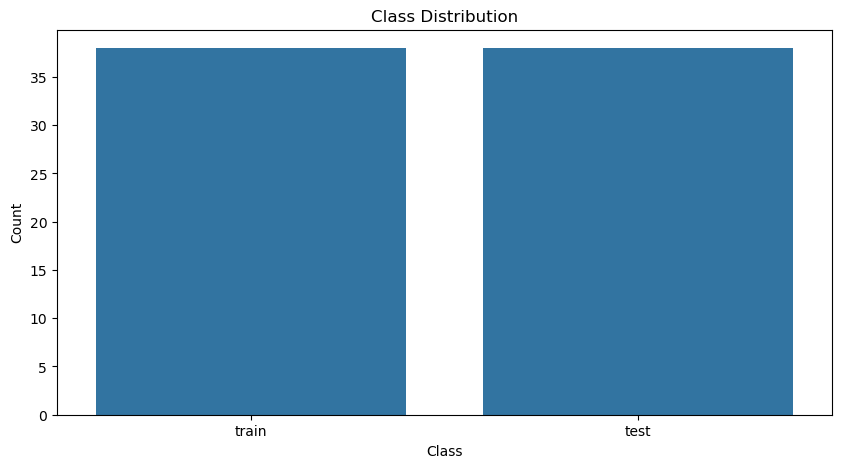

In [13]:
# Function to plot class distribution
def plot_class_distribution(directory):
    class_counts = [len(os.listdir(os.path.join(directory, class_folder))) for class_folder in os.listdir(directory)]
    class_labels = os.listdir(directory)
    
    plt.figure(figsize=(10, 5))
    sns.barplot(x=class_labels, y=class_counts)
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.show()

# Define the path to your dataset
dataset_directory = './dataset'

# Plot class distribution
plot_class_distribution(dataset_directory)

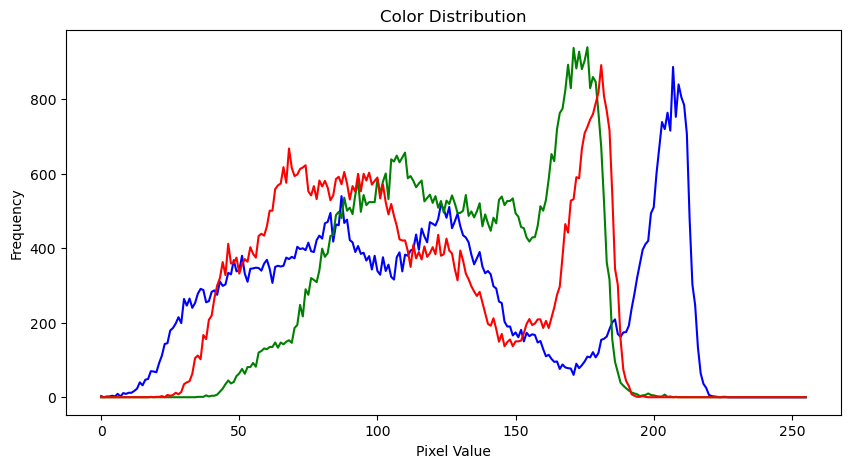

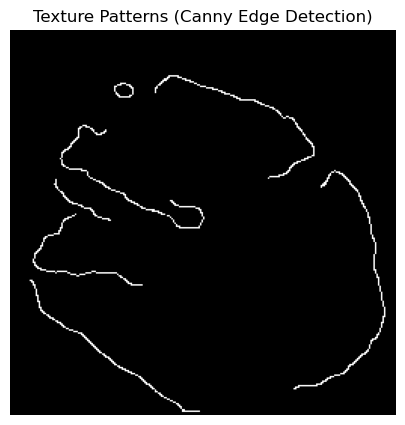

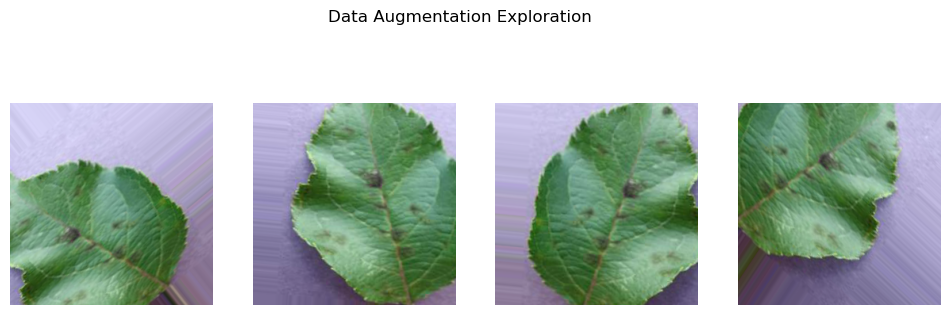

In [14]:
# Function to display color distribution
def display_color_distribution(img):
    colors = ('b', 'g', 'r')
    
    plt.figure(figsize=(10, 5))
    
    for i, color in enumerate(colors):
        hist = cv2.calcHist([img], [i], None, [256], [0, 256])
        plt.plot(hist, color=color)
    
    plt.title('Color Distribution')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.show()

# Function to display texture patterns
def display_texture_patterns(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = feature.canny(gray, sigma=3)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(edges, cmap='gray')
    plt.title('Texture Patterns (Canny Edge Detection)')
    plt.axis('off')
    plt.show()

# Display color distribution and texture patterns for a sample image
sample_image_path = dataset_directory + '/train/Apple___Apple_scab/00075aa8-d81a-4184-8541-b692b78d398a___FREC_Scab 3335.JPG'  # you can change this path
sample_img = cv2.imread(sample_image_path)

display_color_distribution(sample_img)
print()
display_texture_patterns(sample_img)
print()

# Data augmentation exploration
augmentation_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Generate augmented images for a sample image
img = image.load_img(sample_image_path, target_size=(256, 256))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

augmented_images = augmentation_datagen.flow(x, batch_size=1)

num_images = len(augmented_images)
num_images = max(num_images, 4)

plt.figure(figsize=(12, 4))
for i in range(num_images):
    plt.subplot(1, num_images, i + 1)
    img = np.squeeze(augmented_images[0])
    plt.imshow(image.array_to_img(img))
    plt.axis('off')

plt.suptitle('Data Augmentation Exploration')
plt.show()

In [15]:
# Dataset is huge I just reduced them (Please run it once!)
def copy_images(source_dir, dest_dir, num_images):
    # Set the random seed
    random.seed(1)
    
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)

    for class_folder in os.listdir(source_dir):
        class_source_dir = os.path.join(source_dir, class_folder)
        class_dest_dir = os.path.join(dest_dir, class_folder)

        if not os.path.exists(class_dest_dir):
            os.makedirs(class_dest_dir)

        images = os.listdir(class_source_dir)
        selected_images = sample(images, num_images)

        for image in selected_images:
            shutil.copy(os.path.join(class_source_dir, image), class_dest_dir)

# Define your directories
train_dir = 'dataset/train'
test_dir = 'dataset/test'

# Create new directories for the selected images
new_train_dir = 'selected_dataset/train'
new_test_dir = 'selected_dataset/test'

# Check if the directories exist and contain the required number of subfolders
if os.path.exists(new_train_dir) and os.path.exists(new_test_dir):
    if len(os.listdir(new_train_dir)) == 38 and len(os.listdir(new_test_dir)) == 38:
        print("The directories already exist and contain the required number of subfolders.")
    else:
        # Copy the images
        copy_images(train_dir, new_train_dir, 200)
        copy_images(test_dir, new_test_dir, 60)
else:
    # Create directories if they do not exist
    os.makedirs(new_train_dir, exist_ok=True)
    os.makedirs(new_test_dir, exist_ok=True)
    # Copy the images
    copy_images(train_dir, new_train_dir, 200)
    copy_images(test_dir, new_test_dir, 60)



The directories already exist and contain the required number of subfolders.


## Preprocessing

In [16]:
train_dataset_path = "selected_dataset/train"
test_dataset_path = "selected_dataset/test"
batch_size = 32

In [17]:
# Preprocessing
# Set up image data generation with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=50,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [18]:
# Load the training set and validation sets
train_generator = train_datagen.flow_from_directory(
    train_dataset_path,
    target_size=(256, 256),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True

)

validation_generator = test_datagen.flow_from_directory(
    test_dataset_path,
    target_size=(256, 256),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

Found 7600 images belonging to 38 classes.
Found 2280 images belonging to 38 classes.


In [19]:
# Number of classes
num_classes = len(train_generator.class_indices)
num_classes

38

## Model Training

In [21]:
# Define the model without a inner layer
def build_model(hp):
    model = Sequential()
    model.add(Conv2D(filters=hp.Int('conv_1_filter', min_value=32, max_value=64, step=32),
                     kernel_size=hp.Choice('conv_1_kernel', values = [3]),
                     activation='relu',
                     input_shape=(256,256,3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=32),
                 kernel_size=hp.Choice('conv_2_kernel', values = [3]),
                 activation='relu',
                 input_shape=(256,256,3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(units=hp.Int('dense_1_units', min_value=64, max_value=128, step=32),
                    activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.1, max_value=0.3, default=0.1, step=0.10)))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', values=[0.01, 0.001, 0.002])),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Perform hyperparameter tuning
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='output',
    project_name='PhytoPhinder: The Leaf Disease Detective'
)

tuner.search_space_summary()

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)

tuner.search(
    train_generator,
    epochs=25,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('dense_1_units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


Trial 5 Complete [01h 34m 16s]
val_accuracy: 0.547149121761322

Best val_accuracy So Far: 0.7997806966304779
Total elapsed time: 07h 11m 40s

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 64 and the optimal learning rate for the optimizer
is 0.001.



In [22]:
# Build the model with the optimal hyperparameters
model = tuner.hypermodel.build(best_hps)

# Retrain the model
history = model.fit(train_generator, epochs = 25, validation_data = validation_generator)

# Save the model
model.save('best_model.h5')


Epoch 1/25
238/238 [==============================] - 114s 477ms/step - loss: 3.1583 - accuracy: 0.1603 - val_loss: 2.5237 - val_accuracy: 0.2947
Epoch 2/25
238/238 [==============================] - 113s 473ms/step - loss: 2.3391 - accuracy: 0.3251 - val_loss: 1.9729 - val_accuracy: 0.4482
Epoch 3/25
238/238 [==============================] - 113s 474ms/step - loss: 2.0505 - accuracy: 0.3905 - val_loss: 1.6736 - val_accuracy: 0.4833
Epoch 4/25
238/238 [==============================] - 113s 474ms/step - loss: 1.8151 - accuracy: 0.4547 - val_loss: 1.6033 - val_accuracy: 0.5039
Epoch 5/25
238/238 [==============================] - 113s 473ms/step - loss: 1.6991 - accuracy: 0.4842 - val_loss: 1.5355 - val_accuracy: 0.5518
Epoch 6/25
238/238 [==============================] - 113s 474ms/step - loss: 1.5763 - accuracy: 0.5191 - val_loss: 1.3148 - val_accuracy: 0.6026
Epoch 7/25
238/238 [==============================] - 114s 477ms/step - loss: 1.4718 - accuracy: 0.5424 - val_loss: 1.1255 -

# Test with the Best Model

In [2]:
# Load the best model
best_model = load_model('capstone-1/models/best_model_notebook_1.h5')

In [36]:
# Load an image for prediction
img_path = 'dataset/test/Strawberry___healthy/00166615-5e7b-4318-8957-5e50df335ee8___RS_HL 1785_180deg.JPG'  # Provide the path to your image
img = image.load_img(img_path, target_size=(256, 256))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

# Get the predictions
predictions = best_model.predict(img_array)

# Assuming it's a multiclass classification, you can get the class with the highest probability
predicted_class = np.argmax(predictions)

# Print the result
print(f'Predicted class: {predicted_class}')

1/1 [==============================] - 0s 25ms/step
Predicted class: 27
